In [6]:
#import scalecast
import tensorflow
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
#from scalecast.Forecaster import Forecaster
# If a column or index cannot be represented as an array of datetimes,
# say because of an unparsable value or a mixture of timezones,
# the column or index will be returned unaltered as an object data type.

df = pd.read_csv('DailyDelhiClimateTrain.csv',parse_dates=['date'])
# take a look at the data
df.head()
#len(df)

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


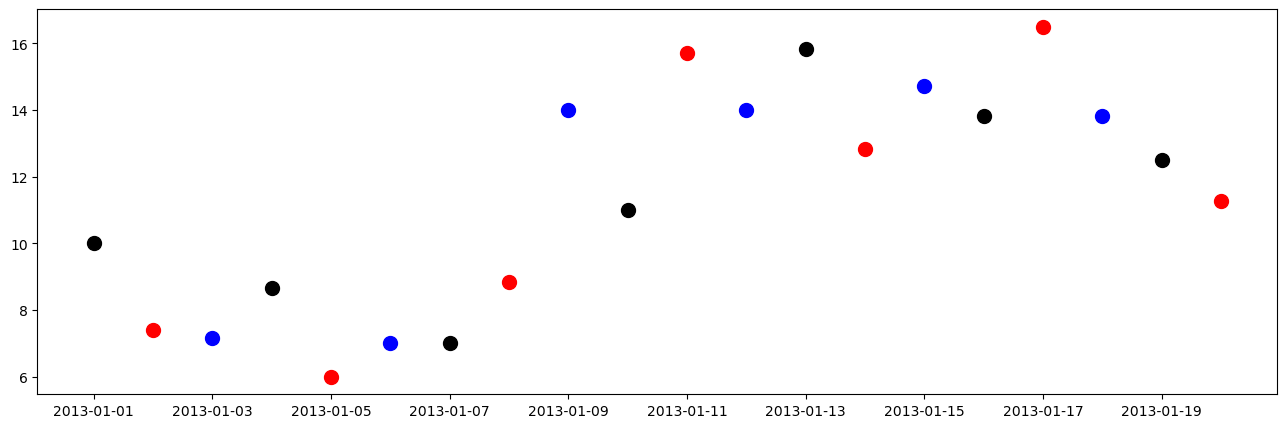

In [7]:
# lags =3
df_plot= df[:20]

labels = 'a b c a b c a b c a b c a b c a b c a b'.split()
colors = dict(zip(set(labels), 'red,blue,black'.split(',')))

fig = plt.subplots(figsize=(16, 5))

tupels = zip(df_plot['meantemp'], df_plot['date'])
for (x,y), label in zip(tupels, labels):
    plt.scatter( y, x, color=colors[label], zorder=1, s=100)

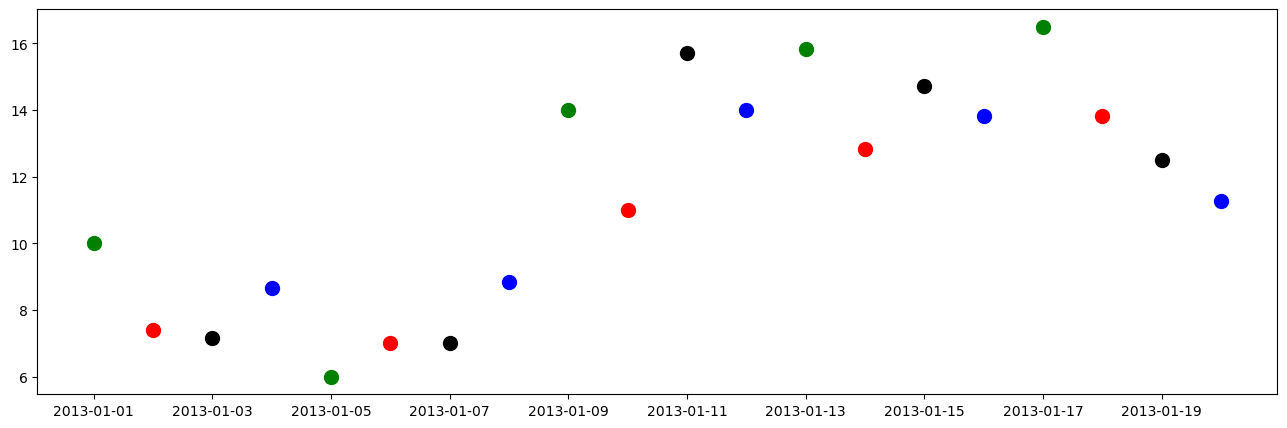

In [8]:
# lags =4 
df_plot_4= df[:20]

labels = 'a b c d a b c d a b c d a b c d a b c d'.split()
colors = dict(zip(set(labels), 'red,blue,black,green'.split(',')))

fig = plt.subplots(figsize=(16, 5))

tupels = zip(df_plot_4['meantemp'], df_plot_4['date'])
for (x,y), label in zip(tupels, labels):
    plt.scatter( y, x, color=colors[label], zorder=0, s=100)

In [9]:
df_plot= df[:20]
tupels = zip(df_plot['meantemp'], df_plot['date'])
#for t in tupels:
   # print(t)
for (x,y), label in zip(tupels, labels):
    print((x,y), label)

(10.0, Timestamp('2013-01-01 00:00:00')) a
(7.4, Timestamp('2013-01-02 00:00:00')) b
(7.166666666666667, Timestamp('2013-01-03 00:00:00')) c
(8.666666666666666, Timestamp('2013-01-04 00:00:00')) d
(6.0, Timestamp('2013-01-05 00:00:00')) a
(7.0, Timestamp('2013-01-06 00:00:00')) b
(7.0, Timestamp('2013-01-07 00:00:00')) c
(8.857142857142858, Timestamp('2013-01-08 00:00:00')) d
(14.0, Timestamp('2013-01-09 00:00:00')) a
(11.0, Timestamp('2013-01-10 00:00:00')) b
(15.714285714285714, Timestamp('2013-01-11 00:00:00')) c
(14.0, Timestamp('2013-01-12 00:00:00')) d
(15.833333333333334, Timestamp('2013-01-13 00:00:00')) a
(12.833333333333334, Timestamp('2013-01-14 00:00:00')) b
(14.714285714285714, Timestamp('2013-01-15 00:00:00')) c
(13.833333333333334, Timestamp('2013-01-16 00:00:00')) d
(16.5, Timestamp('2013-01-17 00:00:00')) a
(13.833333333333334, Timestamp('2013-01-18 00:00:00')) b
(12.5, Timestamp('2013-01-19 00:00:00')) c
(11.285714285714286, Timestamp('2013-01-20 00:00:00')) d


Let’s decompose this time series by viewing the PACF (Partial Auto Correlation Function) plot, which measures how much the y variable(meantemp) is correlated to past values of itself.
blue area PACF plots depicts the significance threshold. That means, lags that located within this area is statistically close to zero and thus insignificant autocorrelation
between data points.

PACF will depicts intuitively correlations of 1  at  lag  0, since this represents the correlation of the time series with itself.
This plot indicates significant autocorrelation at lag 1 which means that adjacent points (have lag of 1) are highly correlated
there are non zero autocorrelation at different lags as well.

C:\Users\la2022\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


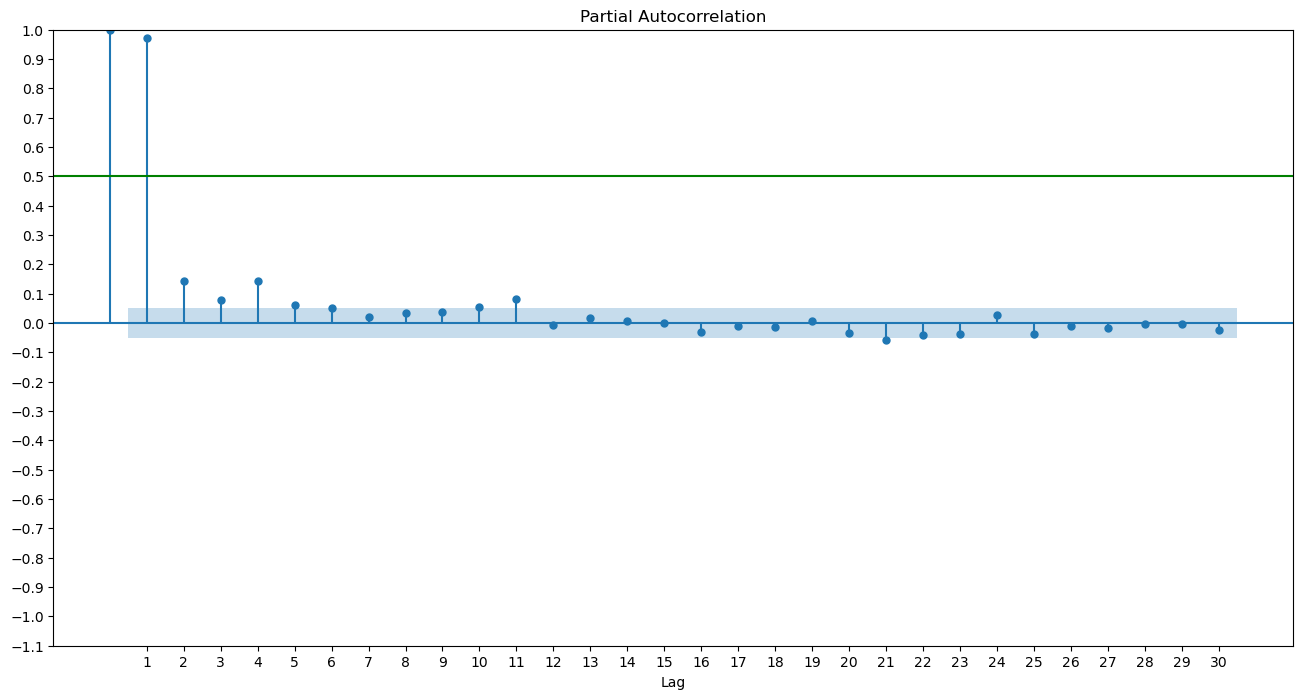

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
fig, ax = plt.subplots(figsize=(16,8))

plot_pacf(df['meantemp'], lags=30, ax=ax)
plt.ylim([0,1])
plt.yticks(np.arange(-1.1, 1.1, 0.1))
plt.xticks(np.arange(1, 31, 1))
plt.axhline(y=0.5, color="green")
plt.xlabel('Lag')
plt.show()
plt.show()

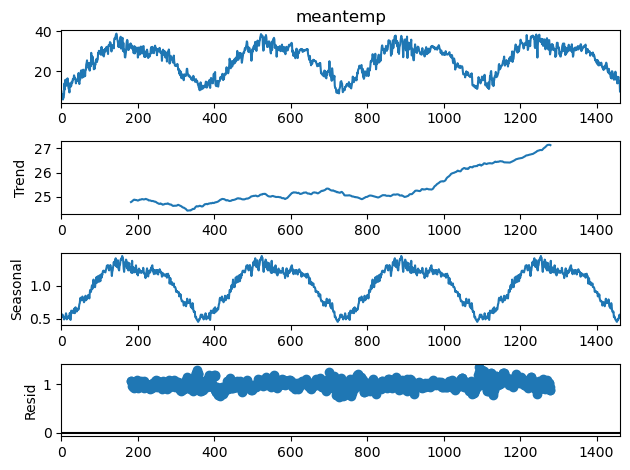

In [11]:
# Let’s further decompose the series into its trend, seasonal, and residual parts:
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['meantemp'],  model='multiplicative', period=365)# requency of the observations is 1
result.plot()
pyplot.show()
#The figure obviously indicates yearly seasonality and increasing trend over time.

 let’s test the series’ stationarity. If bool (full_res = False), returns whether the test suggests stationarity.
 Null Hypothesis of Augmented Dickey-Fuller (ADF) test: time series is non_stationary ( there is a unit root,).
If the pvalue is above a critical size (Default is 0.05), then we cannot reject that there is a unit root.




In [12]:
stat = adfuller(df['meantemp'])
print(stat)
#p_value is 0.28 > 0.05, then we cannot reject null hypothesis and thus time series is non stationary

(-2.021069055920671, 0.2774121372301611, 10, 1451, {'1%': -3.4348647527922824, '5%': -2.863533960720434, '10%': -2.567831568508802}, 5423.895746470953)


In [13]:
# prepare input data, 30 datapoints will be incorporated by LSTM as historical data to produce 1 forecast
ts = df['meantemp']
len(ts)

1462

In [14]:
# prepare input sequences
ts = df['meantemp']
train = ts[:1000]
test = ts[1000:]
# reset test data index
test.reset_index(drop=True, inplace=True)
lags = 30

Y_train = []
Y_test = []
X_train = []
X_test = []
# training data
for j in range(len(train) -lags):
     
    inp= train[j:j +lags]
    out= train[j + lags]
    X_train.append(inp)
    Y_train.append(out)    
print(len(X_train))
print(len(Y_train))

970
970


In [15]:
# reshaping training data
X_train = np.reshape(X_train, (len(X_train), lags, 1))
Y_train = np.reshape(Y_train, (len(X_train), 1))

print(X_train.shape)
print(Y_train.shape)


(970, 30, 1)
(970, 1)


In [16]:
#building LSTM 
# dense(units,..), units: Positive integer, dimensionality of the output space;
# dense layer will output the predicted minimum temprature..
# input shape: (batch size, seq_len, 1)

import keras
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation
from keras.layers import LSTM
from keras import optimizers

model = Sequential() 


#optimizer; learning rate
adam = optimizers.Adam(learning_rate=0.001)
# return_sequence to return a hidden state for each time step in the input sequence
# in our model: when return_sequences=True, the output of the first lstm layer will be of shape (none, 30, 64)
# whereas for return_sequences=false the output will be of shape (none, 64), since only one value (and not sequence) is returned for each sequence

# input layer of 64 units
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True ))

model.add(LSTM(32))# hidden layer of 32 units

model.add(Dense(Y_train.shape[1]))# = 1

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


In [17]:
#fitting model on training data
model.compile(optimizer=adam, loss='mae')
model.fit(X_train, Y_train , epochs=300, batch_size= 50, verbose=1)

Epoch 1/300
20/20 [==============================] - 2s 16ms/step - loss: 23.8759
Epoch 2/300
20/20 [==============================] - 0s 16ms/step - loss: 21.8124
Epoch 3/300
20/20 [==============================] - 0s 16ms/step - loss: 20.7310
Epoch 4/300
20/20 [==============================] - 0s 16ms/step - loss: 20.1673
Epoch 5/300
20/20 [==============================] - 0s 16ms/step - loss: 19.4988
Epoch 6/300
20/20 [==============================] - 0s 16ms/step - loss: 18.7728
Epoch 7/300
20/20 [==============================] - 0s 16ms/step - loss: 18.2936
Epoch 8/300
20/20 [==============================] - 0s 16ms/step - loss: 17.8262
Epoch 9/300
20/20 [==============================] - 0s 17ms/step - loss: 17.3667
Epoch 10/300
20/20 [==============================] - 0s 16ms/step - loss: 16.9126
Epoch 11/300
20/20 [==============================] - 0s 18ms/step - loss: 16.4635
Epoch 12/300
20/20 [==============================] - 0s 18ms/step - loss: 16.0208
Epoch 13/300


20/20 [==============================] - 0s 23ms/step - loss: 1.1270
Epoch 199/300
20/20 [==============================] - 0s 22ms/step - loss: 1.1563
Epoch 200/300
20/20 [==============================] - 0s 23ms/step - loss: 1.1607
Epoch 201/300
20/20 [==============================] - 0s 22ms/step - loss: 1.1553
Epoch 202/300
20/20 [==============================] - 0s 23ms/step - loss: 1.1523
Epoch 203/300
20/20 [==============================] - 0s 23ms/step - loss: 1.1369
Epoch 204/300
20/20 [==============================] - 0s 23ms/step - loss: 1.1313
Epoch 205/300
20/20 [==============================] - 0s 22ms/step - loss: 1.1469
Epoch 206/300
20/20 [==============================] - 0s 23ms/step - loss: 1.1241
Epoch 207/300
20/20 [==============================] - 0s 23ms/step - loss: 1.1350
Epoch 208/300
20/20 [==============================] - 0s 23ms/step - loss: 1.1269
Epoch 209/300
20/20 [==============================] - 0s 22ms/step - loss: 1.1450
Epoch 210/300
20/2

In [18]:
# testing sequences, prepare testing data
X_test=[]
Y_test=[]
for j in range(len(test) - lags):
     
    inp_test= test[j:j + lags]
    out_test= test[j + lags]
    X_test.append(inp_test)
    Y_test.append(out_test) 
#reshape test data
X_test = np.reshape(X_test, (len(X_test), lags, 1))
print(len(X_test))
print(len(Y_test))    
    

432
432


14/14 [==============================] - 0s 4ms/step


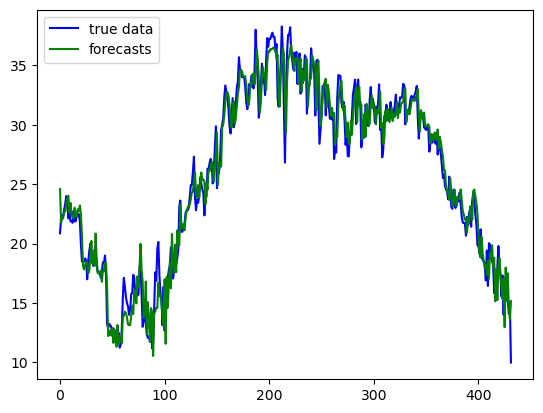

In [21]:
# plot forecasts vs real data
import matplotlib.pyplot as plt
forecasts= model.predict(X_test)
plt.plot(Y_test, label ='true data', color="blue")
plt.plot(forecasts, label='forecasts', color="green")
plt.legend(loc="upper left")
plt.show()

In [22]:
# evaluate the forecasts: calculate the MAPE value between actual data and forecasts
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(Y_test, forecasts)
mape

0.05421930991000218